# Practice 6

1. Importing libraries
2. Load and prepare samsum dataset
3. Fine-tune and evaluate FLAN-T5
4. Run Inference and Experiment with Prompts


## Quick intro about FLAN-T5

FLAN-T5 released with the [Scaling Instruction-Finetuned Language Models](https://arxiv.org/pdf/2210.11416.pdf) paper is an enhanced version of T5 that has been finetuned in a mixture of tasks. The paper explores instruction finetuning with a particular focus on (1) scaling the number of tasks, (2) scaling the model size, and (3) finetuning on chain-of-thought data. 

From the [HuggingFace model card's](https://huggingface.co/google/flan-t5-small) convenient TLDR:

"If you already know T5, FLAN-T5 is just better at everything. For the same number of parameters, these models have been fine-tuned on more than 1000 additional tasks covering also more languages"

It performs well on a wide range of natural language processing tasks, including language translation, text classification, and question answering. The model is known for its speed and efficiency, making it an attractive option for real-time applications.

But in this notebook we will look at the ablity of FLAN-T5 to do text summarization: FLAN-T5 can be fine-tuned to generate concise summaries of long articles and documents, making it ideal for news aggregation and information retrieval.

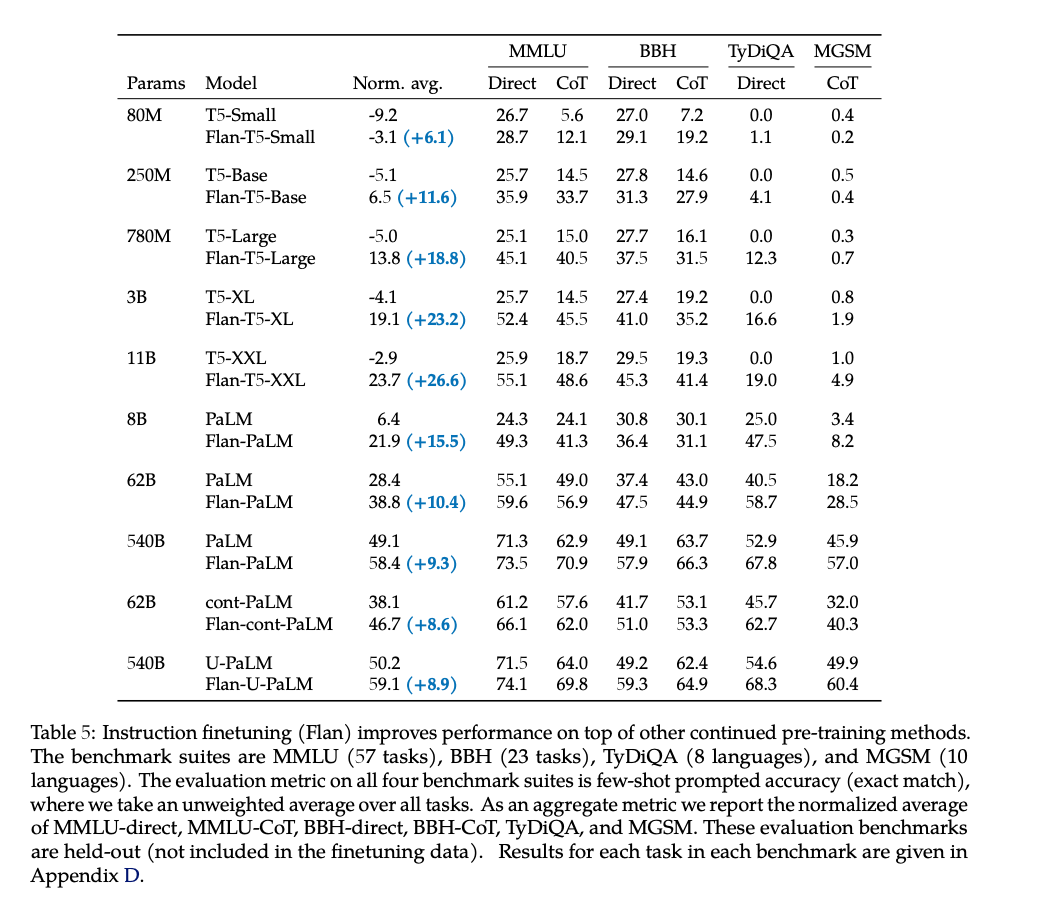

Google’s Flan-T5 is available via 5 pre-trained chekpoints:

Flan-T5 small

Flan-T5-base

Flan-T5-large

Flan-T5-XL

Flan-T5 XXL

## 1. Importing libraries

In [19]:
!pip install pytesseract transformers datasets bleu sacrebleu rouge-score nltk tensorboard py7zr --upgrade
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
import torch

# Check for CUDA availability for GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device {device}')

device cuda


## 2. Load and prepare samsum dataset

we will use the [samsum](https://huggingface.co/datasets/samsum) dataset a collection of about 16k messenger-like conversations with summaries. Conversations were created and written down by linguists fluent in English.

```json
{
  "id": "13818513",
  "summary": "Amanda baked cookies and will bring Jerry some tomorrow.",
  "dialogue": "Amanda: I baked cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)"
}
```

In [21]:
dataset_id = "samsum"

To load the `samsum` dataset, we use the `load_dataset()` 


In [22]:
from datasets import load_dataset

# Load dataset from the hub
dataset = load_dataset(dataset_id)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [23]:
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 14732
Test dataset size: 819


Lets checkout an example of the dataset.

In [24]:
from random import randrange        


sample = dataset['train'][randrange(len(dataset["train"]))]
print(f"dialogue: \n{sample['dialogue']}\n---------------")
print(f"summary: \n{sample['summary']}\n---------------")

dialogue: 
Maria: We've passed the security and we're waiting for the boarding
Aldona: no problems?
Philip: not at all, was smooth
Aldona: I told you
Maria: I know, but I am traumatised after the stopped me the last time
Maria: it was so stressful and horrible, quite humiliating
Aldona: I know, but it should not happen again
Philip: She is panicking all the time
Philip: it would be even funny, if it wasn't so annoying
Maria: I'm sorry, it's kind of a phobia I guess
Aldona: no, it will pass, you just had very bad experiences
Maria: maybe you're right
Maria: I feel already better, thanks guys for your support
Aldona: 👍
---------------
summary: 
Maria and Philip passed the security and they are waiting for the boarding. Last time she flew Maria was stopped by security guards.
---------------


To train our model we need to convert our inputs (text) to token IDs. To do this we will use AutoTokenizer

In [25]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id="google/flan-t5-small"

# Load tokenizer of FLAN-t5-small
tokenizer = AutoTokenizer.from_pretrained(model_id)


before we can start training we need to preprocess our data. Abstractive Summarization is a text2text-generation task. This means our model will take a text as input and generate a summary as output. 

In [26]:
from datasets import concatenate_datasets

# The maximum total input sequence length after tokenization. 
# Sequences longer than this will be truncated, sequences shorter will be padded.
tokenized_inputs = concatenate_datasets([dataset["train"], dataset["test"]]).map(lambda x: tokenizer(x["dialogue"], truncation=True), batched=True, remove_columns=["dialogue", "summary"])
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])
print(f"Max source length: {max_source_length}")

# The maximum total sequence length for target text after tokenization. 
# Sequences longer than this will be truncated, sequences shorter will be padded.
tokenized_targets = concatenate_datasets([dataset["train"], dataset["test"]]).map(lambda x: tokenizer(x["summary"], truncation=True), batched=True, remove_columns=["dialogue", "summary"])
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])
print(f"Max target length: {max_target_length}")

Max source length: 512


Map:   0%|          | 0/15551 [00:00<?, ? examples/s]

Max target length: 95


In [27]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = ["summarize: " + item for item in sample["dialogue"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["summary"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["dialogue", "summary", "id"])
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


## 3. Fine-tune and evaluate FLAN-T5

After we have processed our dataset, we can start training our model. Therefore we first need to load our FLAN-T5 from the Hugging Face. 

In [28]:
from transformers import AutoModelForSeq2SeqLM

# huggingface hub model id
model_id="google/flan-t5-small"

# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

We want to evaluate our model during training. The `Trainer` supports evaluation during training by providing a `compute_metrics`.  
The most commonly used metrics to evaluate model on generative task are:

ROUGE (Recall-Oriented Understudy for Gisting Evaluation): ROUGE is a widely used metric for evaluating the quality of machine-generated text by comparing it to one or more reference texts (usually human-generated). It measures the overlap of n-grams (i.e., words or sequences of words) between the generated text and reference text. The ROUGE metric includes multiple variants such as ROUGE-N (for unigrams, bigrams, etc.), ROUGE-L (for the longest common subsequence), and ROUGE-W (for weighted scores).

BLEU (Bilingual Evaluation Understudy): BLEU is another popular metric for evaluating the quality of machine-generated text, particularly in machine translation tasks. It measures the n-gram overlap between the generated text and reference text. It's a simple and widely used metric to assess the quality of generated text.

We are going to use evaluate library to evaluate the rogue and bleu scores.

In [29]:
import evaluate
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize
from datasets import load_metric


nltk.download("punkt")

# Metric
metric_rouge = evaluate.load("rouge")
metric_bleu = load_metric("sacrebleu")

# Helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Compute ROUGE scores
    rouge_scores = metric_rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    rouge_scores = {k: round(v * 100, 4) for k, v in rouge_scores.items()}
    
    # Compute BLEU score
    references = [[label.split()] for label in decoded_labels]
    predictions = [pred.split() for pred in decoded_preds]
    bleu_score = metric_bleu.compute(predictions=predictions, references=references)
    bleu_score = {'bleu': round(bleu_score['score'], 4)}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result = {**rouge_scores, **bleu_score, "gen_len": round(np.mean(prediction_lens), 4)}
    return result

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Before we can start training is to create a DataCollator that will take care of padding our inputs and labels. We will use the DataCollatorForSeq2Seq 

In [30]:
from transformers import DataCollatorForSeq2Seq

# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)


In [31]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments


output_id = f"{model_id.split('/')[1]}-{dataset_id}"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=output_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False, # Overflows with fp16
    learning_rate=5e-5,
    num_train_epochs=5, # number of epochs we want our model to train
    # logging & evaluation strategies
    logging_dir=f"{output_id}/logs",
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    # metric_for_best_model="overall_f1"
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

We can start our training by using the `train` method of the `Trainer`.

In [32]:
# Start training
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Gen Len
1,1.839500,1.668295,42.866000,18.673700,35.561800,39.073700,20.922000,16.947500
2,1.761200,1.647513,43.159100,18.806500,35.599900,39.241200,20.978200,16.907200
3,1.724000,1.640559,43.588800,19.266200,36.102700,39.618900,20.942800,16.641000
4,1.692000,1.638269,43.634300,19.152000,36.103400,39.629000,21.015800,16.781400
5,1.684000,1.638387,43.493400,19.033600,35.948600,39.468700,21.037000,16.866900


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars

TrainOutput(global_step=4605, training_loss=1.7378308059079381, metrics={'train_runtime': 2333.477, 'train_samples_per_second': 31.567, 'train_steps_per_second': 1.973, 'total_flos': 1.369269457649664e+16, 'train_loss': 1.7378308059079381, 'epoch': 5.0})

In [33]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.6382691860198975,
 'eval_rouge1': 43.6343,
 'eval_rouge2': 19.152,
 'eval_rougeL': 36.1034,
 'eval_rougeLsum': 39.629,
 'eval_bleu': 21.0158,
 'eval_gen_len': 16.7814,
 'eval_runtime': 32.7617,
 'eval_samples_per_second': 24.999,
 'eval_steps_per_second': 1.587,
 'epoch': 5.0}

## 4. Run Inference


In [47]:
from transformers import pipeline
from random import randrange        

sample = dataset['test'][randrange(len(dataset["test"]))]

prompt = "Summarize the following dialogue. " + sample['dialogue']

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to('cuda')  # Ensure input is on the same device as the model

# Generate the summary
summary_ids = model.generate(input_ids, max_length=100, num_beams=4, length_penalty=2.0, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(f"dialogue: \n{sample['dialogue']}\n")
print("-------------------------------------------")
print(f"Summary: {sample['summary']}\n")
print("-------------------------------------------")
print(f"Model's Summary: {summary}\n")

dialogue: 
Harry: heyyyy are you there??
Cindy: Yes dear what is it?
Harry: Can you call Ela and tell her i need to talk urgent please pick my call.
Cindy: what happened now? an other fight :O
Harry: please tell her
Cindy: MAN! you guys... am i some kind of a messenger service here?
Harry: PLEASEEEEEEEEE ?
Cindy: ok doing.... but thats the last time.
Harry: Yes like always:P
Cindy: Hate you seriously man.
Harry: Thank you
Cindy: Done you can call her now.

-------------------------------------------
Summary: Ela is not taking Harry's phone calls. Cindy calls Ela at Harry's request.

-------------------------------------------
Model's Summary: Harry will call Ela and tell her she needs to talk urgently. Cindy will call her.



In [34]:
# Experiment with Prompts
prompts = [
    "Summarize the following dialogue.",
    "Provide a concise summary of the conversation.",
    "Answer the question in a brief summary.",
    "Capture the emotional tone of the conversation.",
    "Provide a summary that captures the context and key points.",
    "Summarize the dialogue with a focus on opinions and preferences.",
    "Summarize the roles and responsibilities discussed in the conversation.",
    "Compare and contrast the views in the conversation.",
]
    
for prompt in prompts:
    print(f"Prompt: {prompt}")
    input_text = f"{prompt} NATASHA: What time is it? We’re going to be late! TONY: It’s a quarter after seven. We’re on time. Don’t panic. NATASHA: But I thought we had to be at the restaurant by 7:30 for the surprise party. We’ll never make it there with all this evening traffic. TONY: Sure we will. Rush hour is almost over. Anyway, the party starts at 8:00. But I do need help with directions. Can you call the restaurant and ask them where we park our car?"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to('cuda')  # Ensure input is on the same device as the model

    # Generate the summary
    summary_ids = model.generate(input_ids, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f"Summary: {summary}\n")

Prompt: Summarize the following dialogue.
Summary: NATASHA and TONY are going to be late for the surprise party. They will be at the restaurant by 7:30 for the surprise party.

Prompt: Provide a concise summary of the conversation.
Summary: NATASHA, TONY and TONY are going to be late for the surprise party. They will be at the restaurant by 7:30.

Prompt: Answer the question in a brief summary.
Summary: NATASHA and TONY are going to be late for the surprise party. They will be at the restaurant by 7:30 for the surprise party. The party starts at 8:00.

Prompt: Capture the emotional tone of the conversation.
Summary: NATASHA and TONY are going to be late for the surprise party. They will be at the restaurant by 7:30 for the surprise party.

Prompt: Provide a summary that captures the context and key points.
Summary: NATASHA and TONY are going to be late for the surprise party at the restaurant by 7:30. The party starts at 8:00.

Prompt: Summarize the dialogue with a focus on opinions an